In [117]:
%pip install duckdb
%pip install seaborn
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
from collections import namedtuple

row_limit = 0
# row_limit = 1000000
sheetreader_threads = [1,4,8]

TableConfig = namedtuple('Table', ['name', 'scale_factor'])
table_configs = [TableConfig('orders',1)
                 , TableConfig('customer',1)
                 , TableConfig('part',1)
                #  , TableConfig('lineitem',1)
                #  , TableConfig('nation',1)
                 ]

Table = namedtuple('Table', ['name', 'scale_factor', 'xlsx_file_path', 'result_file_path'])
file_suffix = 'tr_' + '_'.join(str(th) for th in sheetreader_threads)
tables = [Table(table.name, table.scale_factor
                , f'./tpch_{table.name}_sf_{table.scale_factor}_rl_{row_limit}.xlsx'
                , f'./tpch_{table.name}_sf_{table.scale_factor}_rl_{row_limit}_{file_suffix}_results.csv')
                for table in table_configs]

append_results = False

duckdb_executable_path = '../build/release/duckdb'
runs_per_function = 2
enable_spatial_benchmarks = True

db_folder_path = './'

tr_1_4_8


In [2]:
import duckdb
import os

def create_tpch_db(scale_factor=1):
    db_file_path = f"{db_folder_path}tpch_sf_{scale_factor}.db"
    if not os.path.isfile(db_file_path):
        try:
            print(f"Creating TPC-H data for scale factor {scale_factor}")
            con = duckdb.connect(database = db_file_path)
            con.execute("INSTALL tpch;")
            con.execute("LOAD tpch;")
            con.execute(f"CALL dbgen(sf = {scale_factor});")
            print(f"Created TPC-H data for scale factor {scale_factor}")

        except Exception as e:
            con.close()
            print(e)

    return db_file_path

def create_tpch_xlsx(output_file_name, scale_factor=1, tpch_table_name="customer"):
    db_file_path = create_tpch_db(scale_factor)
    con = duckdb.connect(database = db_file_path)
    try:
        con.execute("INSTALL spatial;")
        con.execute("LOAD spatial;")

        all_cols = con.execute(f"DESCRIBE {tpch_table_name};").fetchall()

        decimal_columns = []

        for column in all_cols:
            column_name = column[0]
            column_type = column[1]

            if 'DECIMAL' in column_type:
                decimal_columns.append(column_name)

        for column in decimal_columns:
            col_name = column
            bigint_col_name = f"{col_name}_bigint"
            con.execute(f"ALTER TABLE {tpch_table_name} ADD COLUMN {bigint_col_name} BIGINT;")
            con.execute(f"UPDATE {tpch_table_name} SET {bigint_col_name} = CAST({col_name} AS BIGINT);")
            con.execute(f"ALTER TABLE {tpch_table_name} DROP COLUMN {col_name};")
            con.execute(f"ALTER TABLE {tpch_table_name} RENAME COLUMN {bigint_col_name} TO {col_name};")

        if row_limit > 0:
            con.execute(f"COPY (SELECT * FROM {tpch_table_name} LIMIT {row_limit}) TO '{output_file_name}' WITH (FORMAT GDAL, DRIVER 'xlsx');")
        else:
            con.execute(f"COPY (SELECT * FROM {tpch_table_name}) TO '{output_file_name}' WITH (FORMAT GDAL, DRIVER 'xlsx');")

        con.close()
    except Exception as e:
        con.close()
        print(e)


In [3]:
import os
for table in tables:
  if not os.path.isfile(table.xlsx_file_path):
    print(f"Creating XLSX file for TPC-H table {table.name} with scale factor {table.scale_factor} and row limit {row_limit}")
    create_tpch_xlsx(table.xlsx_file_path, table.scale_factor, table.name)
  else:
    print(f"Skipping creation of XLSX file for TPC-H table {table.name} with scale factor {table.scale_factor} and row limit {row_limit}")

Skipping creation of XLSX file for TPC-H table orders with scale factor 1 and row limit 0
Skipping creation of XLSX file for TPC-H table customer with scale factor 1 and row limit 0
Creating XLSX file for TPC-H table part with scale factor 1 and row limit 0
Creating TPC-H data for scale factor 1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created TPC-H data for scale factor 1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [4]:
import timeit
import pandas as pd
import subprocess

def run_st_read(xlsx_file_path, runs_per_query=1, sheetreader_threads=[1], past_results=None):
    results = pd.DataFrame(columns=['function', 'time'])

    if past_results is not None:
        # Select only function and time columns
        results[['function','time']] = past_results[['function', 'time']].copy()

    def run(fn, fn_name):
        results.loc[len(results)] = [fn_name, timeit.timeit(fn, number=1)]
    def run_query(query):
        subprocess.run([duckdb_executable_path], input=query.encode(), stdout=subprocess.PIPE)
    def run_st_read():
        sql_stmt = f"load spatial; create table tmp_sp as from st_read('{xlsx_file_path}');"
        # Run ./duckdb_local with sql_stmt as input
        run_query(sql_stmt)
    def run_sheetreader(threads=1):
        sql_stmt = f"load sheetreader; create table tmp_sr as from sheetreader('{xlsx_file_path}', threads={threads});"
        # Run ./duckdb_local with sql_stmt as input
        return lambda : run_query(sql_stmt)

    run_query(f"install spatial;")

    def print_status(run, total_runs, suffix=''):
        print(f"Run {run}/{total_runs} - {suffix.ljust(20)}", end='\r')


    for i in range(runs_per_query):
        print_status(i+1, runs_per_query)
        if enable_spatial_benchmarks:
            print_status(i+1, runs_per_query, 'Spatial')
            run(run_st_read, 'Spatial')
        for thread in sheetreader_threads:
            print_status(i+1, runs_per_query, f'SheetReader with {thread} threads')
            run(run_sheetreader(thread), f'SheetReader {thread} Thread{"s" if thread > 1 else ""}')

    print("\n")
    return results


In [5]:
for table in tables:
  if not os.path.isfile(table.result_file_path):
    results = run_st_read(table.xlsx_file_path, runs_per_function, sheetreader_threads)
    results.to_csv(table.result_file_path)
  elif append_results:
    print(f"Appending results to file {table.result_file_path}")
    old_results = pd.read_csv(table.result_file_path)
    results = run_st_read(table.xlsx_file_path, runs_per_function, sheetreader_threads, old_results)
    results.to_csv(table.result_file_path)
  else:
    print(f"Skipping benchmark for TPC-H table {table.name} with scale factor {table.scale_factor}")


Skipping benchmark for TPC-H table orders with scale factor 1
Skipping benchmark for TPC-H table customer with scale factor 1
Run 2/2 - SheetReader with 8 threads



In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def save_plot(plot_name):
  plt.tight_layout()
  if row_limit > 0:
    plt.savefig(f'{plot_name}_benchmark_{row_limit}_rows{"" if enable_spatial_benchmarks else "_wo_spatial"}.png')
  else:
    plt.savefig(f'{plot_name}_benchmark_sf_{table.scale_factor}{"" if enable_spatial_benchmarks else "_wo_spatial"}.png')
  plt.show()
  # Clear the plot
  plt.clf()


def create_boxplot(table, results):
  # load the results from the csv
  results = pd.read_csv(table.result_file_path)

  sns.set_style("whitegrid")


  ax = sns.boxplot(data=results, x="function", y="time", fill=False, gap=.1)

  plot_title = f"Time to read XLSX file (TPH-C {table.name} Table - Scale Factor {table.scale_factor})"
  ax.set(xlabel='', ylabel='Time (s)', title=plot_title)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  ax.set(ylim=(0, max(results['time']) * 1.2))
  # Change ascpect ratio of the plot
  # ax.set_aspect(1)

  save_plot("boxplot")


def create_barplot(table, results):
  # ax = sns.barplot(
  #     data=results, x="function", y="time",
  #     errorbar=("pi", 50), capsize=.4,
  #     err_kws={"color": ".5", "linewidth": 2.5},
  #     linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0),
  # )
  ax = sns.catplot(
      data=results, x="function", y="time",
      kind="bar",
      # height=4, aspect=.5,
  )
  plot_title = f"Time to read XLSX file (TPC-H {table.name} Table - Scale Factor {table.scale_factor})"
  ax.set(xlabel='', ylabel='Time (s)', title=plot_title)
  for axes in ax.axes.flat:
      axes.set_xticklabels(axes.get_xticklabels(), rotation=40, ha="right")

  save_plot("barplot")

def joined_plot(df):
  ax = sns.catplot(
      data=df, x="table", y="time", hue="function",
      kind="bar",
      # height=4, aspect=.5,
  )
  plot_title = f"Time to read XLSX file - TPC-H Tables"
  if row_limit > 0:
    plot_title += f" with {row_limit} rows"
  ax.set(xlabel='', ylabel='Time (s)', title=plot_title)
  # Remove the hue legend
  ax._legend.remove()
  plt.legend(title='Function')
  save_plot("joined_barplot")





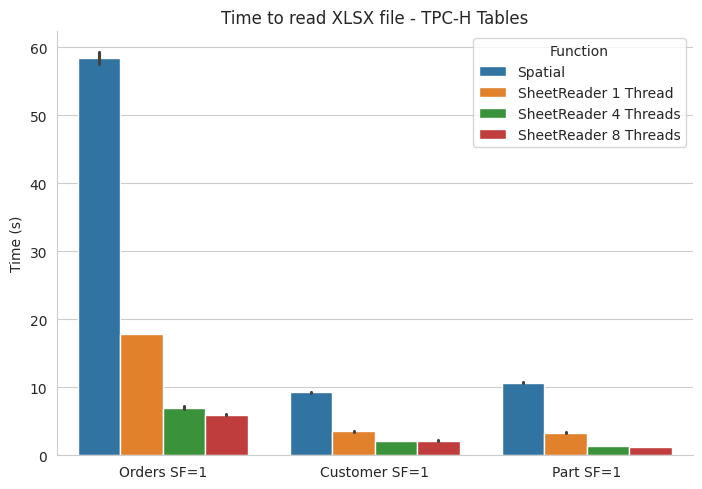

,Unnamed: 0,function,time,table
0,0,Spatial,57.499145,Orders SF=1
1,1,SheetReader 1 Thread,17.777564,Orders SF=1
2,2,SheetReader 4 Threads,7.195228,Orders SF=1
3,3,SheetReader 8 Threads,6.070785,Orders SF=1
4,4,Spatial,59.339912,Orders SF=1
5,5,SheetReader 1 Thread,17.769288,Orders SF=1
6,6,SheetReader 4 Threads,6.762360,Orders SF=1
7,7,SheetReader 8 Threads,5.886578,Orders SF=1
0,0,Spatial,9.214090,Customer SF=1
1,1,SheetReader 1 Thread,3.435776,Customer SF=1


<Figure size 640x480 with 0 Axes>

In [15]:
def join_benchmarks(tables):
  if row_limit > 0:
    joined_results = [pd.read_csv(table.result_file_path).assign(table=f"{table.name.capitalize()}") for table in tables ]
  else:
    joined_results = [pd.read_csv(table.result_file_path).assign(table=f"{table.name.capitalize()} SF={table.scale_factor}") for table in tables ]
  joined_results = pd.concat(joined_results)
  return joined_results

all_results = join_benchmarks(tables)
joined_plot(all_results)
all_results

/tmp/ipykernel_17262/3293243797.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


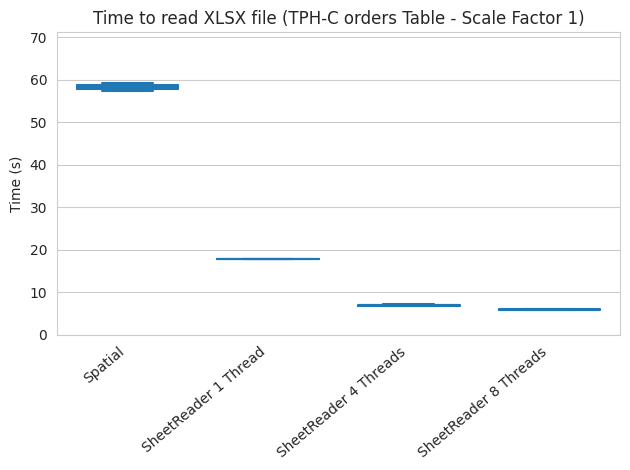

/tmp/ipykernel_17262/3293243797.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=40, ha="right")


<Figure size 640x480 with 0 Axes>

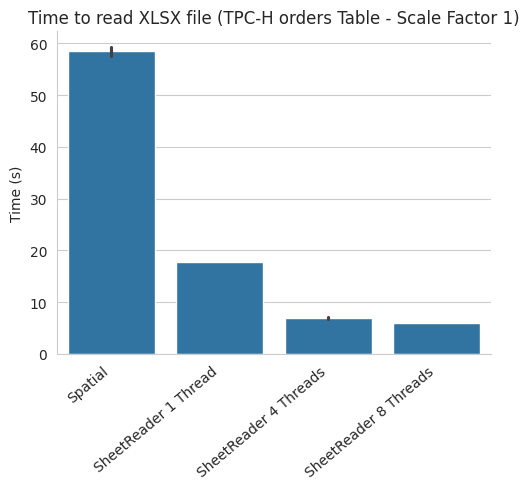

/tmp/ipykernel_17262/3293243797.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


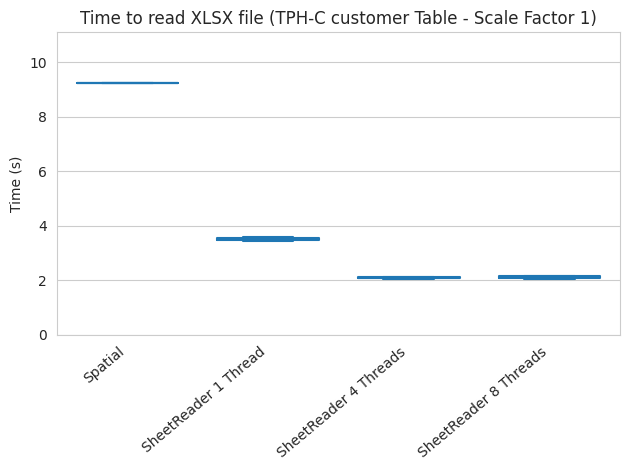

/tmp/ipykernel_17262/3293243797.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=40, ha="right")


<Figure size 640x480 with 0 Axes>

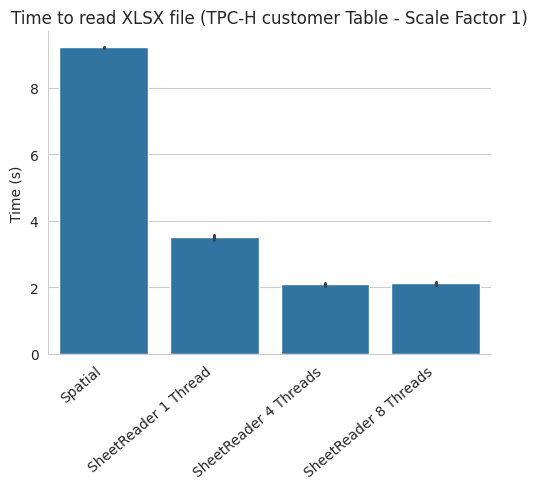

/tmp/ipykernel_17262/3293243797.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


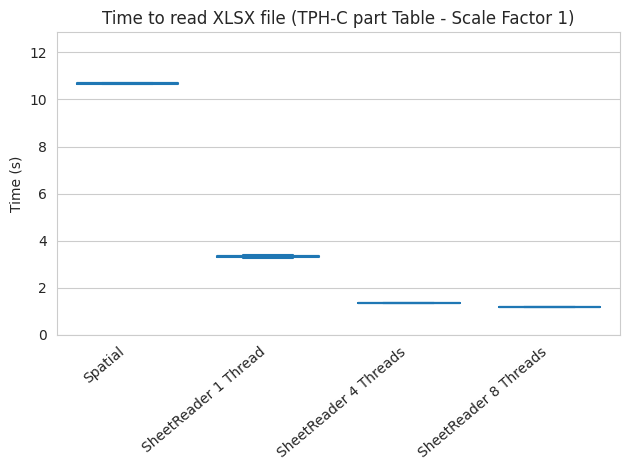

/tmp/ipykernel_17262/3293243797.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=40, ha="right")


<Figure size 640x480 with 0 Axes>

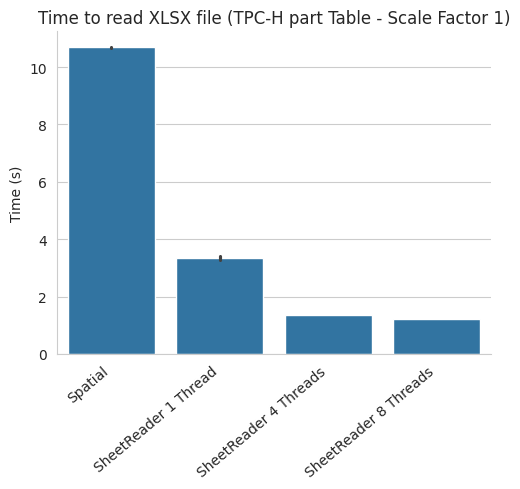

<Figure size 640x480 with 0 Axes>

In [16]:
for table in tables:
  results = pd.read_csv(table.result_file_path)
  create_boxplot(table, results)
  create_barplot(table, results)